## 关于单独unit的可视化，需要另外进行x_test的重新“样本返回”，然后取对应的“id”进行预测就可以。
##  取任意id发动机进行单独可视化的代码暂时不公开，如果有需要的csdn私聊我，不刀，50元，科研不易，尊重劳动成果。最后感谢各位支持

In [2]:
%load_ext autoreload
%autoreload 2
# 需要在TF上跑的，可以在keras前添加tensorflow——from  tensorflow.keras.xxxx import xxxx
# from util.campss_diy import Model_to_save,Model_to_load
import os 
import sys

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import RMSprop,Adam,Adadelta,Nadam,Adamax,Adagrad
from tensorflow.keras.callbacks import History
from tensorflow.keras import callbacks,Input
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.utils import plot_model
from tensorflow import keras

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('seaborn-whitegrid')#绘图的主题
plt.rcParams['font.sans-serif'] = 'Times New Roman'
plt.rcParams.update({'font.size': 12}) # 改变所有字体大小，改变其他性质类似

import warnings
warnings.filterwarnings('ignore')


import tensorflow as tf
#TF2.0以上的设置方法
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# config = tf.compat.v1.ConfigProto(allow_soft_placement=True)
# config.gpu_options.per_process_gpu_memory_fraction = 0.3
# tf.compat.v1.keras.backend.set_session(tf.compat.v1.Session(config=config))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Setting seed for reproducibility
np.random.seed(1234)

# Input files don't have column names
dependent_var = ['RUL']#依赖的变量
index_columns_names =  ["UnitNumber","Cycle"]
operational_settings_columns_names = ["OpSet"+str(i) for i in range(1,4)]#添加操作条件1,2,3,
sensor_measure_columns_names =["Sensor"+str(i) for i in range(1,22)]#添加传感器编号1，…，21
#输入发动机编号/运行时间/设置/哪个传感器数据/
input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

## 读取训练集

In [4]:
#pandas读取数据/True:以，为分割符/names:指定列名
df_train = pd.read_csv('../../dataset/train_FD001.txt',delim_whitespace=True,names=input_file_column_names)

rul = pd.DataFrame(df_train.groupby('UnitNumber')['Cycle'].max()).reset_index()
rul.columns = ['UnitNumber', 'max']
#将每一Unitnumber中最大的Cycle找到，并在原来的df_train中添加新的colum，位置为Unitnumber的左边，也即在最右端
df_train = df_train.merge(rul, on=['UnitNumber'], how='left')
#计算出RUL对应的各个值
df_train['RUL'] = df_train['max'] - df_train['Cycle']
#然后在把最大的max去掉
df_train.drop('max', axis=1, inplace=True)

df_train

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [5]:
#https://www.jb51.net/article/155584.htm
#https://www.jb51.net/article/151614.htm

In [6]:
df_train

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


## 读取测试集

#### 方便可视化测试集，计算“截断的”RUL值：注意这里还不是Actual_RUL

In [7]:
df_test = pd.read_csv('../../dataset/test_FD001.txt',delim_whitespace=True,names=input_file_column_names)
"""为了方便测试集的每一个unit的可视化，需要给测试集算出真实的RUL列值"""
rul = pd.DataFrame(df_test.groupby('UnitNumber')['Cycle'].max()).reset_index()
rul.columns = ['UnitNumber', 'max']
#将每一Unitnumber中最大的Cycle找到，并在原来的df_train中添加新的colum，位置为Unitnumber的左边，也即在最右端
df_test = df_test.merge(rul, on=['UnitNumber'], how='left')
#计算出RUL对应的各个值
"""此时还不是真实剩余RUL"""
df_test['RUL'] = df_test['max'] - df_test['Cycle']
#然后在把最大的max去掉
df_test.drop('max', axis=1, inplace=True)

df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,30
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,29
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,28
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,27
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,26


In [8]:
y_true = pd.read_csv('../../dataset/RUL_FD001.txt',delim_whitespace=True,names=["RUL"])
"""注意：这里UnitNumber=1=测试集的UnitNumber"""
y_true["UnitNumber"] = y_true.index+1
y_true

,RUL,UnitNumber
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5
...,...,...
95,137,96
96,82,97
97,59,98
98,117,99


In [9]:
"""首先制作以UnitNumber为ID的真是RUL的DataFrame"""
actual_rul = pd.DataFrame(y_true.groupby('UnitNumber')['RUL'].max()).reset_index()
actual_rul.columns = ['UnitNumber', 'acrul']
df_test = df_test.merge(actual_rul, on=['UnitNumber'], how='left')
df_test.head()

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL,acrul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,30,112
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,29,112
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,28,112
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,27,112
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,26,112


In [10]:
"""最终才是真实的测试集RUL"""
df_test['RUL'] = df_test['RUL']+df_test['acrul']
#然后在把最大的acrul去掉
df_test.drop('acrul', axis=1, inplace=True)

df_test

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [11]:
"""采用分段线性退化假说：参照相关的文献，其分段的RUL认为>=130的RUL值，均标记为RUL=130
    注意：部分文献的分段RUL=125
    github上面一般也没有这样处理的代码，但是论文都是用的120-130
"""
def fun(x):
    if x >= 125:
        return 125
    else:
        return x

In [12]:
df_test['RUL']=df_test['RUL'].apply(lambda x: fun(x))
df_test

,UnitNumber,Cycle,OpSet1,OpSet2,OpSet3,Sensor1,Sensor2,Sensor3,Sensor4,Sensor5,...,Sensor13,Sensor14,Sensor15,Sensor16,Sensor17,Sensor18,Sensor19,Sensor20,Sensor21,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,125
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,125
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,125
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,125
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13091,100,194,0.0049,0.0000,100.0,518.67,643.24,1599.45,1415.79,14.62,...,2388.00,8213.28,8.4715,0.03,394,2388,100.0,38.65,23.1974,24
13092,100,195,-0.0011,-0.0001,100.0,518.67,643.22,1595.69,1422.05,14.62,...,2388.09,8210.85,8.4512,0.03,395,2388,100.0,38.57,23.2771,23
13093,100,196,-0.0006,-0.0003,100.0,518.67,643.44,1593.15,1406.82,14.62,...,2388.04,8217.24,8.4569,0.03,395,2388,100.0,38.62,23.2051,22
13094,100,197,-0.0038,0.0001,100.0,518.67,643.26,1594.99,1419.36,14.62,...,2388.08,8220.48,8.4711,0.03,395,2388,100.0,38.66,23.2699,21


In [13]:
y_true['RUL']=y_true['RUL'].apply(lambda x: fun(x))
y_true

,RUL,UnitNumber
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5
...,...,...
95,125,96
96,82,97
97,59,98
98,117,99


## 数据分析

## 绘制小提琴图

## 拥有最大RUL的排序首位五个

## 拥有最大RUL的排序，末尾的五个

## 三个工况的操作条件可视化，选择其中一个单元

## 选择其中一个单元进行传感器数据的可视化

### 去除没必要的传单其数据

In [14]:
# necessary features for analysis

"""FD001&FD003"""
not_required_feats = ["Sensor1", "Sensor5", "Sensor6", "Sensor10", "Sensor16", "Sensor18", "Sensor19"]

# """FD002"""
# not_required_feats = []


feats = [feat for feat in sensor_measure_columns_names if feat not in not_required_feats]
feats

['Sensor2',
 'Sensor3',
 'Sensor4',
 'Sensor7',
 'Sensor8',
 'Sensor9',
 'Sensor11',
 'Sensor12',
 'Sensor13',
 'Sensor14',
 'Sensor15',
 'Sensor17',
 'Sensor20',
 'Sensor21']

### 进行相关性分析

### 可视化在失效之前，传感器的数值

### 查看两个传感器之间的相关性

## 二.数据处理

为了确保特征的方差保持在相同的范围内，缩放特征是很重要的。如果一个特征的方差大于其他特征的方差的数量级，则该特定特征可能支配数据集中的其他特征，这是不可取的。

In [15]:
sequence_length = 36
mask_value = 0
"""选择哪些特征进行预测"""
# feats.append('Cycle')
# feats=feats+operational_settings_columns_names

'选择哪些特征进行预测'

In [16]:
#这里是否出现问题/ MinMaxScaler：归一到 [ 0，1 ] MaxAbsScaler：归一到 [ -1，1 ] 
from sklearn.preprocessing import MaxAbsScaler,MinMaxScaler
min_max_scaler = MinMaxScaler(feature_range=(0,1))

df_train[feats] = min_max_scaler.fit_transform(df_train[feats])
df_test[feats] = min_max_scaler.transform(df_test[feats])


### 自定义数据的三维转换函数

In [17]:
# LSTM希望输入是三维numpy数组的形状，我需要相应地转换训练和测试数据。
def gen_train(id_df, seq_length, seq_cols):
 
    data_array = id_df[seq_cols].values
    #存储的array的shape,第一个维度必须是0，有且仅有这一个，代表这个维度是可拓展的。
    num_elements = data_array.shape[0]
    lstm_array=[]
    
    for start, stop in zip(range(0, num_elements-seq_length+1), range(seq_length, num_elements+1)):
        lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)
    

def gen_target(id_df, seq_length, label):
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length-1:num_elements+1]


def gen_test(id_df, seq_length, seq_cols, mask_value):
    df_mask = pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    df_mask[:] = mask_value
    
    id_df = df_mask.append(id_df,ignore_index=True)
    
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]

    start = num_elements-seq_length
    stop = num_elements
    
    lstm_array.append(data_array[start:stop, :])
    
    return np.array(lstm_array)

In [18]:
#generate train
x_train=np.concatenate(list(list(gen_train(df_train[df_train['UnitNumber']==unit], sequence_length, feats)) 
                            for unit in df_train['UnitNumber'].unique()))
print(x_train.shape)

(17131, 36, 14)


In [19]:
#generate target of train
y_train = np.concatenate(list(list(gen_target(df_train[df_train['UnitNumber']==unit], sequence_length, "RUL")) 
                              for unit in df_train['UnitNumber'].unique()))
y_train.shape

(17131,)

In [20]:
#generate test
x_test=np.concatenate(list(list(gen_test(df_test[df_test['UnitNumber']==unit], sequence_length, feats, mask_value)) 
                           for unit in df_test['UnitNumber'].unique()))
print(x_test.shape)

(100, 36, 14)


In [21]:
#true target of test 
y_test = y_true.RUL.values
y_test.shape

(100,)

In [25]:
# import keras.backend as K
import tensorflow.keras.backend as K
from sklearn.metrics import mean_squared_error

#自定义评价指标
def RMSE(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred -y_true)))

#自定义PHM2008评价函数
def Scoring_2008(Y_true, Y_pred):
    h = Y_pred - Y_true
    g = (-(h-K.abs(h))/2.0)
    f = ((K.abs(h)+h)/2.0)
    return K.sum(K.exp(g/13.0)-1)+K.sum(K.exp(f/10.0)-1)

In [26]:
inputt=Input(shape=(x_train.shape[1],x_train.shape[2]))
x = tf.keras.layers.Conv1D(filters=10,kernel_size=10,activation='tanh',padding='same',
                           kernel_initializer='glorot_uniform')(inputt)
x = tf.keras.layers.Conv1D(filters=10,kernel_size=10,activation='tanh',padding='same',
                           kernel_initializer='glorot_uniform')(x)
x = tf.keras.layers.Conv1D(filters=10,kernel_size=10,activation='tanh',padding='same',
                           kernel_initializer='glorot_uniform')(x)
x = tf.keras.layers.Conv1D(filters=10,kernel_size=10,activation='tanh',padding='same',
                           kernel_initializer='glorot_uniform')(x)
x = tf.keras.layers.Conv1D(filters=10,kernel_size=3,activation='tanh',padding='same',
                           kernel_initializer='glorot_uniform')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(100,activation='tanh')(x)
x = tf.keras.layers.Dense(1,activation='relu')(x)

DCNN_model=Model(inputs=inputt,outputs=x)
#查看网络结构
DCNN_model.summary()
#编译模型 RMSprop,Adam,Adadelta,Nadam,Adamax,Adagrad
"""分段学习率"""
def scheduler(epoch):
    if epoch > 200:
        return 0.0001
    else:
        return 0.001
"""打印学习率，方便查看"""
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr#无衰减策略的学习率
    return lr

optimizer_diy =tf.keras.optimizers.Adam(learning_rate=0.001)
lr_metric = get_lr_metric(optimizer_diy)

DCNN_model.compile(optimizer=optimizer_diy,loss='mse',metrics=['mse','mae',RMSE,Scoring_2008,lr_metric]) 


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 36, 14)]          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 36, 10)            1410      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 36, 10)            1010      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 36, 10)            1010      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 36, 10)            1010      
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 36, 10)            310       
_________________________________________________________________
flatten_1 (Flatten)          (None, 360)               0   

In [28]:
%%time
#训练模型
# """https://blog.csdn.net//article/details/106398881
#     连续保存模型参数model_{epoch:03d}.hdf5；join(save_dir, 'model_Weights_{epoch:03d}.h5')
# """NewComerSyt:period=1,

Batch_size=512
save_dir="../DCNN_复现/FD001_30time/"
if not os.path.exists(save_dir):
                os.makedirs(save_dir)
"""
注意：validation_data=(x_test,y_test)这样是不允许的，算是训练作弊
要么是通过手动从x_train中单独划分(x_vaild,y_vaild),raise后采用validation_data=(x_vaild,y_vaild)
要么通过keras或者tf.keras中的model.fit(validation_split=0.1-0.3)从训练集随机划分
"""
History = DCNN_model.fit(x_train, y_train, epochs=250, batch_size=Batch_size,validation_split=0.20,
                        verbose=2,
            callbacks =[keras.callbacks.EarlyStopping(monitor ='val_loss', min_delta=0,patience=125, verbose=0, mode='min'),
                        keras.callbacks.ModelCheckpoint(os.path.join(save_dir, 'model_Weights_best.h5'),
                                                        monitor='val_loss',save_best_only=True,
                                                        save_weights_only=True, mode='min', verbose=0),
                        keras.callbacks.LearningRateScheduler(scheduler)])


Train on 13704 samples, validate on 3427 samples
Epoch 1/250
13704/13704 - 4s - loss: 9443.3244 - mse: 9443.3242 - mae: 79.1320 - RMSE: 97.0301 - Scoring_2008: 20631332864.0000 - lr: 0.0010 - val_loss: 13023.5145 - val_mse: 13023.5156 - val_mae: 90.7870 - val_RMSE: 110.3132 - val_Scoring_2008: 17333954560.0000 - val_lr: 0.0010
Epoch 2/250
13704/13704 - 0s - loss: 8561.7762 - mse: 8561.7764 - mae: 74.1947 - RMSE: 92.4873 - Scoring_2008: 12201032704.0000 - lr: 0.0010 - val_loss: 12504.4518 - val_mse: 12504.4521 - val_mae: 88.3692 - val_RMSE: 107.9789 - val_Scoring_2008: 13819920384.0000 - val_lr: 0.0010
Epoch 3/250
13704/13704 - 0s - loss: 8151.0683 - mse: 8151.0684 - mae: 71.9042 - RMSE: 90.2253 - Scoring_2008: 9875522560.0000 - lr: 0.0010 - val_loss: 12024.3474 - val_mse: 12024.3477 - val_mae: 86.1454 - val_RMSE: 105.7773 - val_Scoring_2008: 11128144896.0000 - val_lr: 0.0010
Epoch 4/250
13704/13704 - 0s - loss: 7773.5548 - mse: 7773.5542 - mae: 69.8143 - RMSE: 88.1778 - Scoring_2008: 7

Epoch 31/250
13704/13704 - 0s - loss: 3551.3930 - mse: 3551.3926 - mae: 47.5607 - RMSE: 59.5876 - Scoring_2008: 159841264.0000 - lr: 0.0010 - val_loss: 5979.1130 - val_mse: 5979.1133 - val_mae: 59.9537 - val_RMSE: 73.9244 - val_Scoring_2008: 196339712.0000 - val_lr: 0.0010
Epoch 32/250
13704/13704 - 0s - loss: 3516.7772 - mse: 3516.7764 - mae: 47.4120 - RMSE: 59.2849 - Scoring_2008: 146771824.0000 - lr: 0.0010 - val_loss: 5914.3421 - val_mse: 5914.3418 - val_mae: 59.7248 - val_RMSE: 73.5539 - val_Scoring_2008: 181099648.0000 - val_lr: 0.0010
Epoch 33/250
13704/13704 - 0s - loss: 3486.2535 - mse: 3486.2534 - mae: 47.2961 - RMSE: 58.9758 - Scoring_2008: 134909680.0000 - lr: 0.0010 - val_loss: 5854.0009 - val_mse: 5854.0005 - val_mae: 59.5151 - val_RMSE: 73.2101 - val_Scoring_2008: 167532128.0000 - val_lr: 0.0010
Epoch 34/250
13704/13704 - 0s - loss: 3459.2063 - mse: 3459.2061 - mae: 47.1936 - RMSE: 58.7704 - Scoring_2008: 126183696.0000 - lr: 0.0010 - val_loss: 5798.3353 - val_mse: 5798.

Epoch 62/250
13704/13704 - 0s - loss: 3283.2072 - mse: 3283.2065 - mae: 46.8789 - RMSE: 57.2618 - Scoring_2008: 48678528.0000 - lr: 0.0010 - val_loss: 5264.0870 - val_mse: 5264.0869 - val_mae: 57.7860 - val_RMSE: 70.0063 - val_Scoring_2008: 62127596.0000 - val_lr: 0.0010
Epoch 63/250
13704/13704 - 0s - loss: 3283.0064 - mse: 3283.0063 - mae: 46.8829 - RMSE: 57.2584 - Scoring_2008: 48376468.0000 - lr: 0.0010 - val_loss: 5261.8555 - val_mse: 5261.8560 - val_mae: 57.7815 - val_RMSE: 69.9954 - val_Scoring_2008: 61803764.0000 - val_lr: 0.0010
Epoch 64/250
13704/13704 - 0s - loss: 3282.8711 - mse: 3282.8713 - mae: 46.8872 - RMSE: 57.2313 - Scoring_2008: 48010652.0000 - lr: 0.0010 - val_loss: 5258.9362 - val_mse: 5258.9360 - val_mae: 57.7757 - val_RMSE: 69.9811 - val_Scoring_2008: 61380580.0000 - val_lr: 0.0010
Epoch 65/250
13704/13704 - 0s - loss: 3282.8313 - mse: 3282.8315 - mae: 46.8950 - RMSE: 57.2526 - Scoring_2008: 47596612.0000 - lr: 0.0010 - val_loss: 5254.9255 - val_mse: 5254.9258 - 

Epoch 93/250
13704/13704 - 0s - loss: 1382.1963 - mse: 1382.1964 - mae: 25.3023 - RMSE: 37.0565 - Scoring_2008: 7678430.0000 - lr: 0.0010 - val_loss: 2820.7417 - val_mse: 2820.7417 - val_mae: 36.0119 - val_RMSE: 49.4202 - val_Scoring_2008: 8982847.0000 - val_lr: 0.0010
Epoch 94/250
13704/13704 - 0s - loss: 1346.4354 - mse: 1346.4355 - mae: 24.9446 - RMSE: 36.6158 - Scoring_2008: 6912216.5000 - lr: 0.0010 - val_loss: 2748.5515 - val_mse: 2748.5515 - val_mae: 35.3782 - val_RMSE: 48.8230 - val_Scoring_2008: 8017388.0000 - val_lr: 0.0010
Epoch 95/250
13704/13704 - 0s - loss: 1304.1413 - mse: 1304.1412 - mae: 24.4427 - RMSE: 36.0595 - Scoring_2008: 6159651.5000 - lr: 0.0010 - val_loss: 2741.6752 - val_mse: 2741.6753 - val_mae: 35.6826 - val_RMSE: 48.3433 - val_Scoring_2008: 7203241.0000 - val_lr: 0.0010
Epoch 96/250
13704/13704 - 0s - loss: 1280.7588 - mse: 1280.7588 - mae: 24.2268 - RMSE: 35.7502 - Scoring_2008: 5486026.0000 - lr: 0.0010 - val_loss: 2742.7931 - val_mse: 2742.7932 - val_mae

Epoch 124/250
13704/13704 - 0s - loss: 763.4546 - mse: 763.4546 - mae: 17.9694 - RMSE: 27.5752 - Scoring_2008: 982453.8750 - lr: 0.0010 - val_loss: 1610.1582 - val_mse: 1610.1580 - val_mae: 25.9207 - val_RMSE: 36.5916 - val_Scoring_2008: 1034024.8125 - val_lr: 0.0010
Epoch 125/250
13704/13704 - 0s - loss: 766.8939 - mse: 766.8939 - mae: 17.9822 - RMSE: 27.6569 - Scoring_2008: 1052363.3750 - lr: 0.0010 - val_loss: 1569.9929 - val_mse: 1569.9927 - val_mae: 25.6909 - val_RMSE: 36.7544 - val_Scoring_2008: 982855.0625 - val_lr: 0.0010
Epoch 126/250
13704/13704 - 0s - loss: 767.0995 - mse: 767.0994 - mae: 18.1670 - RMSE: 27.6719 - Scoring_2008: 979686.7500 - lr: 0.0010 - val_loss: 1605.6094 - val_mse: 1605.6094 - val_mae: 25.6596 - val_RMSE: 36.3869 - val_Scoring_2008: 1113192.5000 - val_lr: 0.0010
Epoch 127/250
13704/13704 - 0s - loss: 751.7816 - mse: 751.7816 - mae: 17.8038 - RMSE: 27.3538 - Scoring_2008: 878710.8750 - lr: 0.0010 - val_loss: 1661.3876 - val_mse: 1661.3878 - val_mae: 26.822

Epoch 155/250
13704/13704 - 0s - loss: 675.8540 - mse: 675.8540 - mae: 17.0931 - RMSE: 25.9709 - Scoring_2008: 557073.4375 - lr: 0.0010 - val_loss: 1591.0993 - val_mse: 1591.0994 - val_mae: 25.4171 - val_RMSE: 36.2279 - val_Scoring_2008: 2611562.7500 - val_lr: 0.0010
Epoch 156/250
13704/13704 - 0s - loss: 668.8412 - mse: 668.8412 - mae: 16.9853 - RMSE: 25.7980 - Scoring_2008: 560466.6875 - lr: 0.0010 - val_loss: 1464.0865 - val_mse: 1464.0865 - val_mae: 24.4480 - val_RMSE: 35.1522 - val_Scoring_2008: 1658079.6250 - val_lr: 0.0010
Epoch 157/250
13704/13704 - 0s - loss: 672.5573 - mse: 672.5573 - mae: 17.0967 - RMSE: 25.8422 - Scoring_2008: 529072.5000 - lr: 0.0010 - val_loss: 1534.0369 - val_mse: 1534.0367 - val_mae: 24.7902 - val_RMSE: 35.8321 - val_Scoring_2008: 3187971.5000 - val_lr: 0.0010
Epoch 158/250
13704/13704 - 0s - loss: 678.6100 - mse: 678.6100 - mae: 17.2376 - RMSE: 25.9383 - Scoring_2008: 663611.2500 - lr: 0.0010 - val_loss: 1575.0892 - val_mse: 1575.0892 - val_mae: 25.171

Epoch 186/250
13704/13704 - 0s - loss: 629.1115 - mse: 629.1116 - mae: 16.5796 - RMSE: 25.0587 - Scoring_2008: 495839.4688 - lr: 0.0010 - val_loss: 1588.6237 - val_mse: 1588.6235 - val_mae: 25.5075 - val_RMSE: 36.3483 - val_Scoring_2008: 2715175.5000 - val_lr: 0.0010
Epoch 187/250
13704/13704 - 0s - loss: 618.4523 - mse: 618.4523 - mae: 16.5161 - RMSE: 24.8202 - Scoring_2008: 335550.4062 - lr: 0.0010 - val_loss: 1518.9776 - val_mse: 1518.9777 - val_mae: 24.7392 - val_RMSE: 35.6282 - val_Scoring_2008: 2634223.2500 - val_lr: 0.0010
Epoch 188/250
13704/13704 - 0s - loss: 651.8167 - mse: 651.8168 - mae: 17.0159 - RMSE: 25.4942 - Scoring_2008: 419582.0312 - lr: 0.0010 - val_loss: 1351.8274 - val_mse: 1351.8274 - val_mae: 23.8522 - val_RMSE: 34.3382 - val_Scoring_2008: 1147073.7500 - val_lr: 0.0010
Epoch 189/250
13704/13704 - 0s - loss: 622.8967 - mse: 622.8967 - mae: 16.5671 - RMSE: 24.9040 - Scoring_2008: 343448.5312 - lr: 0.0010 - val_loss: 1590.2941 - val_mse: 1590.2942 - val_mae: 24.676

Epoch 217/250
13704/13704 - 0s - loss: 589.4689 - mse: 589.4689 - mae: 16.0387 - RMSE: 24.2402 - Scoring_2008: 252429.2031 - lr: 1.0000e-04 - val_loss: 1471.7621 - val_mse: 1471.7621 - val_mae: 24.2892 - val_RMSE: 35.3406 - val_Scoring_2008: 2752825.2500 - val_lr: 1.0000e-04
Epoch 218/250
13704/13704 - 0s - loss: 580.4718 - mse: 580.4719 - mae: 15.9699 - RMSE: 24.0339 - Scoring_2008: 193186.6719 - lr: 1.0000e-04 - val_loss: 1517.8917 - val_mse: 1517.8916 - val_mae: 24.6254 - val_RMSE: 35.7745 - val_Scoring_2008: 3051028.0000 - val_lr: 1.0000e-04
Epoch 219/250
13704/13704 - 0s - loss: 583.4703 - mse: 583.4703 - mae: 15.9644 - RMSE: 24.1066 - Scoring_2008: 239932.1250 - lr: 1.0000e-04 - val_loss: 1484.0311 - val_mse: 1484.0311 - val_mae: 24.4704 - val_RMSE: 35.4843 - val_Scoring_2008: 2638018.5000 - val_lr: 1.0000e-04
Epoch 220/250
13704/13704 - 0s - loss: 581.3988 - mse: 581.3988 - mae: 15.9550 - RMSE: 24.0852 - Scoring_2008: 239566.7344 - lr: 1.0000e-04 - val_loss: 1453.8008 - val_mse:

Epoch 247/250
13704/13704 - 0s - loss: 578.7404 - mse: 578.7404 - mae: 15.9563 - RMSE: 24.0191 - Scoring_2008: 165594.5312 - lr: 1.0000e-04 - val_loss: 1600.7195 - val_mse: 1600.7196 - val_mae: 25.0608 - val_RMSE: 36.6067 - val_Scoring_2008: 4542109.5000 - val_lr: 1.0000e-04
Epoch 248/250
13704/13704 - 0s - loss: 583.9653 - mse: 583.9653 - mae: 15.9886 - RMSE: 24.1423 - Scoring_2008: 312857.8750 - lr: 1.0000e-04 - val_loss: 1534.9124 - val_mse: 1534.9125 - val_mae: 24.7001 - val_RMSE: 35.9891 - val_Scoring_2008: 3663264.7500 - val_lr: 1.0000e-04
Epoch 249/250
13704/13704 - 0s - loss: 579.2818 - mse: 579.2818 - mae: 15.9655 - RMSE: 24.0038 - Scoring_2008: 203197.4688 - lr: 1.0000e-04 - val_loss: 1475.6394 - val_mse: 1475.6395 - val_mae: 24.3028 - val_RMSE: 35.4392 - val_Scoring_2008: 2995837.2500 - val_lr: 1.0000e-04
Epoch 250/250
13704/13704 - 0s - loss: 580.0156 - mse: 580.0157 - mae: 15.9515 - RMSE: 24.0278 - Scoring_2008: 259941.2031 - lr: 1.0000e-04 - val_loss: 1488.7830 - val_mse:

dict_keys(['loss', 'mse', 'mae', 'RMSE', 'Scoring_2008', 'lr', 'val_loss', 'val_mse', 'val_mae', 'val_RMSE', 'val_Scoring_2008', 'val_lr'])


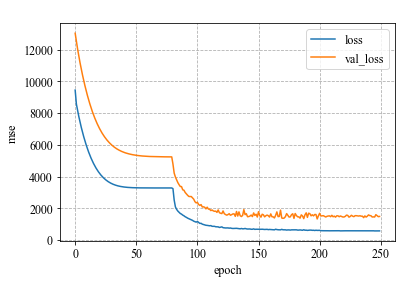

In [29]:
def plotTrainHistory(save_dir,model,title=' '):
    plt.grid(linestyle="--")
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title(title)
    plt.ylabel('mse')
    plt.xlabel('epoch')
    plt.legend(['loss', 'val_loss'], loc='upper right')
    plt.savefig(save_dir+'loss.png' ,bbox_inches='tight', dpi=300)  # 600
    plt.show()
    
print(History.history.keys())
plotTrainHistory(save_dir,History)

In [30]:
DCNN_model.load_weights(os.path.join(save_dir, 'model_Weights_best.h5'))

### 方法一：模型 与 权重分开读取

In [31]:
# ###模型保存2
# dir_P,json_P,weights_P = Model_to_save(model, Bpath="CNN_LSTM_Best_Weights/",
#                                       json_path="Functonal_151_j",
#                                       weights_path="model_Weights_last_only")

# ###模型读取
# # reloaded_model = Model_Load(dir_P,json_P,weights_P)

# reloaded_model = Model_Load(dirs =save_dir,
#                             json_path="Functonal_151_j",
#                             weights_path="model_Weights_best_only")

In [31]:
scores = DCNN_model.evaluate(x_train, y_train, verbose=1, batch_size=Batch_size)
df = pd.DataFrame({'MSE': [scores[1]],
                   'MAE': [scores[2]],
                   'RMSE': [scores[3]],
                  'Scoring_2008':[scores[4]]})

df.transpose().to_csv(save_dir+"评估得分.txt",
                      mode='w',header=['train'],sep=' ',index=["MSE","MAE","RMSE","Scoring_2008"])

17131/17131 [==============================] - 0s 11us/sample - loss: 763.0280 - mse: 763.0280 - mae: 18.5095 - RMSE: 25.7426 - Scoring_2008: 272059.4062 - lr: 1.0000e-04


In [32]:
scores = DCNN_model.evaluate(x_test,y_test, verbose=1, batch_size=Batch_size)
df = pd.DataFrame({'MSE': [scores[1]],
                   'MAE': [scores[2]],
                   'RMSE': [scores[3]],
                  'Scoring_2008':[scores[4]]})

df.transpose().to_csv(save_dir+"评估得分.txt",
                      mode='a',header=['test'],sep=' ',index=["MSE","MAE","RMSE","Scoring_2008"])

100/100 [==============================] - 0s 618us/sample - loss: 707.4045 - mse: 707.4045 - mae: 19.4589 - RMSE: 26.5971 - Scoring_2008: 16585.8750 - lr: 1.0000e-04


### 进行预测

In [33]:
y_pred_test = DCNN_model.predict(x_test,verbose=2)
y_true_test = y_test.reshape(y_test.shape[0],1).astype(np.float32)

100/100 - 0s


In [34]:
"""保存预测的RUL值与实际的RUL值"""
y_pred_test=y_pred_test.reshape(y_pred_test.shape[0]*y_pred_test.shape[1]).astype(np.float32)
y_true_test=y_true_test.reshape(y_true_test.shape[0]*y_true_test.shape[1]).astype(np.float32)
y_All=pd.DataFrame({'Pre':y_pred_test,
                   'Actual':y_true_test})
y_All.to_csv(save_dir+"y_lastpoint_Pre.csv",
                      mode='w',header=["Pre","Actual"],sep=',',index=0)

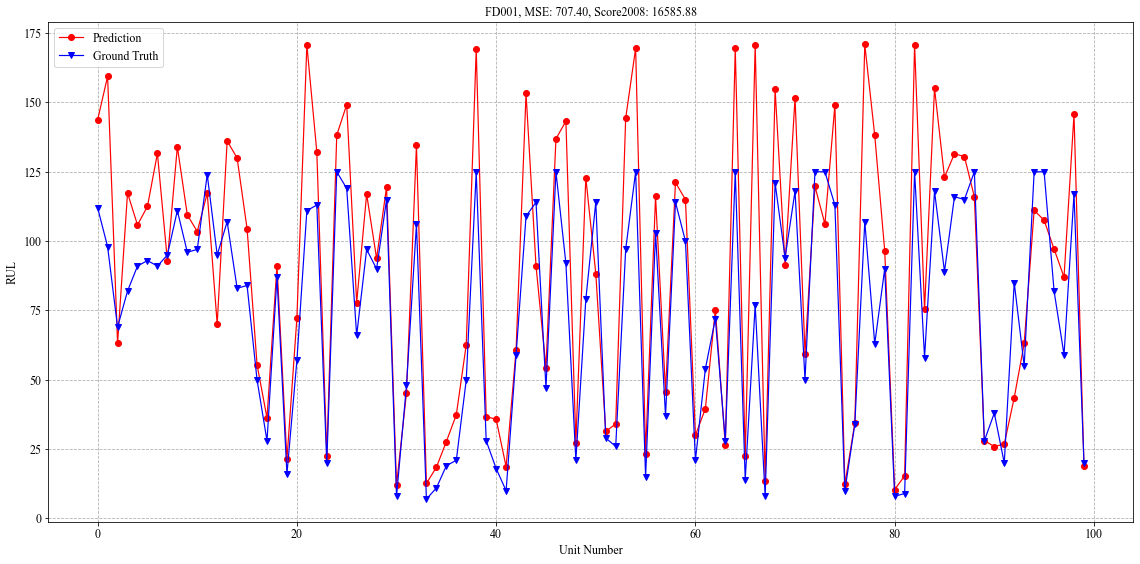

In [37]:
"""测试集所有unitNumber的最后一个值进行可视化"""
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_true_test,y_pred_test)
score_2008 = Scoring_2008(y_true_test,y_pred_test)

fig=plt.figure(figsize=(16,8))
plt.grid(linestyle="--")
plt.plot(y_pred_test, color='red', label='Prediction', marker='o',linestyle='-',linewidth=1.2)
plt.plot(y_true_test, color='blue', label='Ground Truth', marker='v',linestyle='-',linewidth=1.2)
plt.title('FD001'+ ', MSE: '+str('%.2f' % mse)+ ', Score2008: '+str('%.2f' % score_2008),fontsize=12)
plt.ylabel('RUL',fontsize=12)
plt.xlabel('Unit Number' ,fontsize=12)
plt.legend(loc='upper left',fontsize=12)
fig.tight_layout()
plt.savefig(save_dir+'FD001_Last_point_Pre.png' ,bbox_inches='tight', dpi=300)  # 600
plt.show()